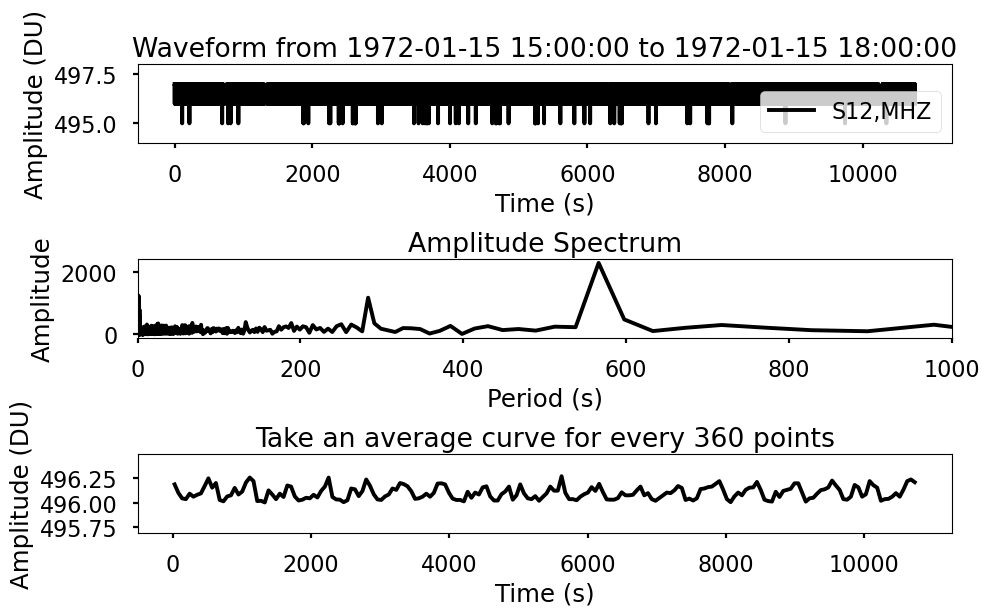

In [6]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import rfft, rfftfreq
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
import matplotlib as mpl
import obspy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from obspy.core import UTCDateTime

# # Apply the custom style
mpl.rcParams.update(mpl.rcParamsDefault)

# Read seismic data streams and interpolate processing
mseed_path = './19720115/waveforms/XA.S12.00.MHZ__*.mseed'
st = obspy.read(str(mseed_path))
data = st[0].data
x_ori = np.arange(0, len(data))
# not -1 location
x = np.where(data != -1)[0]
# not -1 value
data_not_minus_one = data[x]
f = interp1d(x, data_not_minus_one)
data = f(x_ori)
st[0].data = data
stream = st
stream.trim(starttime=UTCDateTime('19720115T150000'), endtime=UTCDateTime('19720115T180000'))

# Extract data and sampling rate from the stream
waveform_data = stream[0].data
sampling_rate = stream[0].stats.sampling_rate
start_time = stream[0].stats.starttime
end_time = stream[0].stats.endtime
station = stream[0].stats.station
channel = stream[0].stats.channel

# Format to a more readable form
formatted_start_time = start_time.strftime("%Y-%m-%d %H:%M:%S")
formatted_end_time = end_time.strftime("%Y-%m-%d %H:%M:%S")

# Calculates the timeline in seconds
times = np.arange(0, end_time-start_time, 1 / sampling_rate)

# If the data length is not a multiple of 360, it is truncated
if len(waveform_data) % 360 != 0:
    waveform_data = waveform_data[:-(len(waveform_data) % 360)]
    times = times[:len(waveform_data)]

# Sets the style and size of the diagram
plt.style.use('seaborn-poster')  # This will automatically increase the font size in all graphs

# The first graph: the original waveform
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(times, waveform_data, color='black', label=f'{station},{channel}')
plt.legend()
plt.title(f'Waveform from {formatted_start_time} to {formatted_end_time}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (DU)')
plt.ylim(np.median(waveform_data)-2,np.median(waveform_data)+2)

# Second graph: Spectrum (use period, not frequency)
plt.subplot(3, 1, 2)
frequencies = rfftfreq(len(waveform_data), 1/sampling_rate)
amplitudes = np.abs(rfft(waveform_data))
periods = 1 / frequencies[frequencies > 0]
modified_amplitudes = amplitudes[1:].copy()  
# Zero out the amplitude beyond 0-1000 seconds
periods_in_range = (periods >= 1/1000) & (periods <= 1000) 
modified_amplitudes[~periods_in_range] = 0
plt.plot(periods, modified_amplitudes, color='black')
plt.xlim(0, 1000) 
plt.title('Amplitude Spectrum')
plt.xlabel('Period (s)')
plt.ylabel('Amplitude')

# The third graph: Average results per 360 points
plt.subplot(3, 1, 3)
averaged_waveform = waveform_data.reshape(-1, 360).mean(axis=1)
# Creates a new timeline that represents the center point time for each average
times_averaged = times[::360] + (360 / 2 / sampling_rate)
plt.plot(times_averaged, averaged_waveform, color='black')
plt.title('Take an average curve for every 360 points')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (DU)')
plt.ylim(np.median(averaged_waveform)-0.4,np.median(averaged_waveform)+0.4)
# Set the Y-axis formatter to avoid scientific notation
y_formatter = ScalarFormatter(useOffset=False)
plt.gca().yaxis.set_major_formatter(y_formatter)

plt.tight_layout()
# plt.savefig('waveform_plots.png')
plt.show()
